# Predicting Severe Injury Outcomes in Traffic Crashes

This project develops machine learning models to predict whether a crash results in severe injury (incapacitated or fatal) using information such as driver characteristics, vehicle attributes, and environmental conditions.

Because severe injuries are relatively rare, the task is formulated as an imbalanced binary classification problem. Multiple models are evaluated, and performance is assessed using metrics appropriate for rare-event prediction, including ROC AUC and Precision–Recall AUC.

The goal is for the model to answer: "Given that a driver is involved in a crash, how likely is the crash to result in a severe injury for the driver?” and select the best model for deployment.

## Data Overview

The dataset contains crash-level records with information on drivers, vehicles, environmental conditions, and safety features. The dataset is from the NHTSA Crash Report Sampling System (CRSS) covering car crushes in the U.S. from 2019–2023.

The outcome variable indicates whether a crash resulted in a severe injury.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/crss_modeling_severe.csv", low_memory=False)
df.shape

(467529, 317)

In [2]:
df["TARGET_SEVERE"].value_counts(normalize=True)

TARGET_SEVERE
0    0.940491
1    0.059509
Name: proportion, dtype: float64

From the procesed dataset of U.S. car crashes: 
- 6% of the drivers in a car crush had severe injuries (incapacitated or fatal)
- 94% of the drivers in a car crush had non-severe injuries

Only about 6% of observations are labeled as severe, this is a highly imbalanced classification problem: 
- Accuracy alone will be misleading, since a model that always predicts “non-severe” would still achieve high accuracy
- Metrics like ROC AUC, PR AUC, recall, precision matter
- Class imbalance handling is needed

## Feature Selection and Leakage Prevention

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

The target variable is separated from the feature set to ensure that no outcome column is used during feature selection or preprocessing.

In [4]:
# target
df["TARGET_SEVERE"] = df["TARGET_SEVERE"].astype(int)
y = df["TARGET_SEVERE"].copy()

# features (start by dropping target)
X = df.drop(columns=["TARGET_SEVERE"]).copy()

print("X shape:", X.shape)
print("y mean:", y.mean())

X shape: (467529, 316)
y mean: 0.05950860802217616


To reduce dimensionality, features are selected based on several keywords. These include driver characteristics, behavior, time, environment,
and vehicle safety attributes that should be available prior to or at the moment of a crash.


In [5]:
# Define pre-crash, Streamlit-safe features (by keyword)
keep_keywords = [
    # driver
    "AGE", "SEX",

    # behavior
    "ALCO", "DRINK", "SPEED",

    # time
    "HOUR", "DAY", "MONTH",

    # environment
    "WEATHER", "LIGHT", "ROAD", "SURFACE",

    # vehicle / protection
    "BODY", "AIR_BAG", "REST"
]

# Keep only columns matching these keywords
model_cols = [
    c for c in X.columns
    if any(k in c.upper() for k in keep_keywords)
]

print("Keeping", len(model_cols), "columns")

X_model = X[model_cols].copy()


Keeping 44 columns


In [36]:
#explicit check to guard against accidental inclusion of post-crash or outcome-related variables.
leakage_terms = ["INJ", "SEV", "FATAL", "HOSP", "EMS"]
assert not any(any(k in c.upper() for k in leakage_terms) for c in X_model.columns)

Only pre-crash variables are used as model inputs. Columns that directly describe injury outcomes or post-crash information are excluded to prevent data leakage. Human-readable label columns are also dropped to avoid redundancy.

In [7]:
#dropping column names with "name" attached as these are repeated columns in human-readable format
drop_name_cols = [c for c in X_model.columns if "NAME" in c]
X_model = X_model.drop(columns=drop_name_cols)
print("X_model shape:", X_model.shape)

X_model shape: (467529, 22)


## Train/test split (stratified)

The data is split into training (80%) and test (20%) sets using stratification to preserve the proportion of severe injuries in both sets.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


print("Train positive rate:", y_train.mean())
print("Test  positive rate:", y_test.mean())

Train positive rate: 0.05950970929595239
Test  positive rate: 0.059504202938848845


## Preprocessing (one-hot encode categoricals)

Some variables are numeric (e.g., age, hour), while others are coded categories (e.g., weather, restraint use).  
Numeric features are standardized, categorical features are one-hot encoded, and missing values are imputed.  
All preprocessing steps are included inside a pipeline to prevent data leakage. 

In [9]:
numeric_cols = [
    "AGE", "AGE_IM",
    "HOUR", "HOUR_IM", "HOUR_acc", "HOUR_veh"
]

categorical_cols = [
    "AIR_BAG", "ALCOHOL",
    "BODY_TYP", "BODY_TYP_veh",
    "DAY_WEEK",
    "DRINKING",
    "MONTH", "MONTH_acc", "MONTH_veh",
    "REL_ROAD",
    "REST_MIS", "REST_USE",
    "SEX", "SEX_IM",
    "SPEEDREL",
    "WEATHER"
]

In [37]:
set(numeric_cols + categorical_cols) == set(X_model.columns) #checking if all columns are selected

True

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # good for logistic; harmless for many models if used separately
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop"
)

In [12]:
Xt = preprocess.fit_transform(X_train)
print("Transformed train shape:", Xt.shape)

Transformed train shape: (374023, 253)


## Testing Three Models

### Logistic Model

We begin with a logistic regression model as a strong, interpretable baseline:
- Outputs calibrated probabilities of severe injury
- Uses class-weight balancing to account for class imbalance
- Works well with high-dimensional one-hot encoded data
- Easy to interpret and compare against more complex models later

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [14]:
logit = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=2000,
            class_weight="balanced"
        ))
    ]
)

In [15]:
logit.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'AGE_IM', 'HOUR',
                                                   'HOUR_IM', 'HOUR_acc',
                                                   'HOUR_veh']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIR_BAG', 'ALCOHOL',
                                                   'BODY_TYP', 'BODY_TYP_veh',
                                                   'DAY_WEEK', 'DRINKING',
                                                   'MONTH', 'MONTH_acc',
                                                   'MONTH_veh', 'REL_ROAD',
                                                   'REST_MIS', 'REST_USE',
                                                   'SEX', 'SEX_IM', 'SPEEDREL',
                                                   'WEATHER'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

### Logistic Model Evaluation

Because severe injury is rare, multiple evaluation metrics are used:

### ROC AUC
Measures how well the model ranks higher-risk cases above lower-risk ones, independent of any decision threshold.

### Precision–Recall (PR) AUC
More informative for imbalanced data.  
The baseline PR AUC equals the prevalence of severe injury (~6%).  
Any model performing substantially above this baseline provides useful signal.

### Classification Thresholds
Predicted probabilities can be converted into class labels using different thresholds depending on the use case:
- Lower threshold → higher recall (fewer missed severe injuries)
- Higher threshold → higher precision (fewer false alarms)


In [16]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

y_proba = logit.predict_proba(X_test)[:, 1]
y_hat = (y_proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)  # PR AUC (Average Precision)
acc = accuracy_score(y_test, y_hat)

roc, pr_auc, acc

(0.8684675580897618, 0.3622880942348246, 0.7914786216927256)

**The logistic regression model achieves:**

- ROC AUC ≈ 0.87, indicating strong ability to rank high-risk crashes above low-risk ones.
- PR AUC ≈ 0.36, which is substantially higher than the baseline severe-injury rate (~0.06), showing meaningful predictive signal despite class imbalance.
- Accuracy ≈ 0.79, though accuracy is less informative here due to the rarity of severe injuries.

Overall, the model performs well at ranking risk and provides useful discrimination beyond chance, even under strong class imbalance.

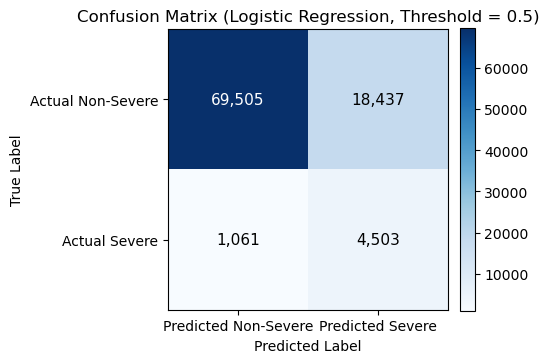

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_hat)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:,}",
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontsize=11)

# Axis labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Predicted Non-Severe", "Predicted Severe"])
ax.set_yticklabels(["Actual Non-Severe", "Actual Severe"])

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix (Logistic Regression, Threshold = 0.5)")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

**Confusion Matrix**

At threshold of 0.5, 
- True Negatives (69,505): correctly predicted non-severe
- False Positives (18,437): predicted severe but actually not
- False Negatives (1,061): severe injuries missed
- True Positives (4,503): severe injuries correctly identified

The model is good at not missing severe cases, but it over-predicts them.


In [43]:
from sklearn.metrics import classification_report

print("Positive rate:", y_test.mean())
print(classification_report(y_test, y_hat, digits=3))

Positive rate: 0.059504202938848845
              precision    recall  f1-score   support

           0      0.985     0.790     0.877     87942
           1      0.196     0.809     0.316      5564

    accuracy                          0.791     93506
   macro avg      0.591     0.800     0.596     93506
weighted avg      0.938     0.791     0.844     93506



At the default threshold of 0.5, the logistic regression model correctly identifies most severe injury cases, achieving a recall of approximately 81%. This indicates strong sensitivity to high-risk crashes, which is desirable in safety-oriented applications.

However, precision is relatively low (≈20%), meaning that many predicted severe cases are false positives. This behavior is expected in highly imbalanced settings where severe outcomes are rare.

Although overall accuracy appears high (≈79%), accuracy alone is misleading in this context, since a model that always predicts “non-severe” would also achieve high accuracy. Therefore, evaluation focuses on recall, precision, and PR AUC, which better capture performance on rare but critical outcomes.


## Precision–Recall Curve

The Precision–Recall curve shows the tradeoff between:
- **Recall**: how many severe injuries are correctly identified
- **Precision**: how many predicted severe injuries are actually severe

The dashed horizontal line represents the baseline (random guessing).
Curves above this line indicate meaningful predictive power.

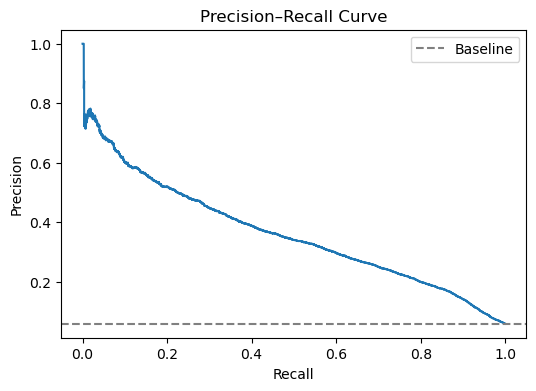

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.axhline(y=y_test.mean(), linestyle="--", color="gray", label="Baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


### Threshold Selection and Decision Policy

Model outputs are probabilities rather than class labels. A default threshold of 0.5 is commonly used but may not appropriate for rare outcomes such as severe injury.

Lowering the classification threshold increases recall (identifying more severe cases) at the cost of lower precision. Conversely, higher thresholds reduce false positives but may miss severe cases. 

To illustrate this tradeoff, we evaluate performance across thresholds using the precision–recall curve above and select a threshold that maximizes the F1 score as an example. This demonstrates how different thresholds can be chosen depending on practical goals, such as prioritizing safety (high recall) or minimizing false alerts (higher precision).

Threshold selection is a policy decision rather than a modeling limitation.


In [38]:
import numpy as np
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx-1]  # thr is shorter by 1
best_thr, prec[best_idx], rec[best_idx], f1[best_idx]

(0.7649703437272067,
 0.3280859841493866,
 0.5431344356578002,
 0.4090693739420009)

In [20]:
thresholds = {
    "Default (0.5)": 0.5,
    "F1-optimal": best_thr
}

for name, t in thresholds.items():
    preds = (y_proba >= t).astype(int)
    print("\n", name)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, digits=3))


 Default (0.5)
[[69505 18437]
 [ 1061  4503]]
              precision    recall  f1-score   support

           0      0.985     0.790     0.877     87942
           1      0.196     0.809     0.316      5564

    accuracy                          0.791     93506
   macro avg      0.591     0.800     0.596     93506
weighted avg      0.938     0.791     0.844     93506


 F1-optimal
[[81752  6190]
 [ 2542  3022]]
              precision    recall  f1-score   support

           0      0.970     0.930     0.949     87942
           1      0.328     0.543     0.409      5564

    accuracy                          0.907     93506
   macro avg      0.649     0.736     0.679     93506
weighted avg      0.932     0.907     0.917     93506



### Interpretation of Results

At the default threshold (0.5):
- The model identifies most severe injuries (high recall)
- Precision is low due to class imbalance; this leads to many false positives, which is expected in highly imbalanced classification problems

At the F1-optimized threshold:
- Precision improves substantially
- Recall decreases moderately
- Improves overall balance between between false positives and false negatives

**Threshold selection is a choice.**

## Random Forest Model

Random Forest is a non-linear ensemble model that builds many decision trees on bootstrapped samples
and aggregates their predictions. Unlike logistic regression, it can automatically capture feature
interactions and non-linear effects.

Class weighting is used to account for the imbalance between severe and non-severe injury cases.


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=50,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'AGE_IM', 'HOUR',
                                                   'HOUR_IM', 'HOUR_acc',
                                                   'HOUR_veh']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIR_BAG', 'ALCOHOL',
                                                   'BODY_TYP', 'BODY_TYP_veh',
                                                   'DAY_WEEK', 'DRINKING',
                                                   'MONTH', 'MONTH_acc',
                                                   'MONTH_veh', 'REL_ROAD',
                                                   'REST_MIS', 'REST_USE',
                                                   'SEX', 'SEX_IM', 'SPEEDREL',
                                                   'WEATHER'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=50, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [23]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_hat_rf = (y_proba_rf >= 0.5).astype(int)

rf_roc = roc_auc_score(y_test, y_proba_rf)
rf_pr  = average_precision_score(y_test, y_proba_rf)
rf_acc = accuracy_score(y_test, y_hat_rf)

rf_roc, rf_pr, rf_acc


(0.8711277364920977, 0.3689382735121923, 0.7892006930036575)

Random Forest captures nonlinear interactions between variables such as vehicle type, restraint use, and environment.

- **ROC AUC ≈ 0.87**, indicating strong ranking ability between severe and non-severe crashes  
- **PR AUC ≈ 0.37**, substantially higher than the baseline prevalence (~6%)  
- **Accuracy ≈ 0.79**, though accuracy is less informative due to class imbalance  

Overall, Random Forest provides slightly better erformance over logistic regression at the cost of reduced interpretability.

## Gradient Boosting Model

Gradient Boosting builds trees sequentially, where each new tree focuses on correcting errors made
by the previous ones. This often leads to stronger predictive performance compared to bagging-based
methods like Random Forest.


In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline([
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'AGE_IM', 'HOUR',
                                                   'HOUR_IM', 'HOUR_acc',
                                                   'HOUR_veh']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIR_BAG', 'ALCOHOL',
                                                   'BODY_TYP', 'BODY_TYP_veh',
                                                   'DAY_WEEK', 'DRINKING',
                                                   'MONTH', 'MONTH_acc',
                                                   'MONTH_veh', 'REL_ROAD',
                                                   'REST_MIS', 'REST_USE',
                                                   'SEX', 'SEX_IM', 'SPEEDREL',
                                                   'WEATHER'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=300,
                                            random_state=42))])

In [25]:
y_proba_gb = gb.predict_proba(X_test)[:, 1]
y_hat_gb = (y_proba_gb >= 0.5).astype(int)

gb_roc = roc_auc_score(y_test, y_proba_gb)
gb_pr  = average_precision_score(y_test, y_proba_gb)
gb_acc = accuracy_score(y_test, y_hat_gb)

gb_roc, gb_pr, gb_acc

(0.8704776037278084, 0.384643181125313, 0.9438431758389836)

### Gradient Boosting Performance

Gradient Boosting achieves the strongest overall performance among the tested models.

- **ROC AUC ≈ 0.87**, indicating strong ability to rank high-risk crashes above low-risk ones  
- **PR AUC ≈ 0.38**, substantially higher than the baseline severe-injury rate (~6%)  
- **Accuracy ≈ 0.94**, though accuracy is less informative due to class imbalance  

Compared to logistic regression and random forest, gradient boosting provides the best precision–recall performance, suggesting it captures nonlinear interactions that improve identification of severe injury cases.


## Model Comparison and Selection

We compare three models: Logistic Regression, Random Forest, and Gradient Boosting.
Performance is evaluated using ROC AUC, PR AUC, and accuracy.

In [26]:
results = pd.DataFrame({
    "Model": ["Logistic", "Random Forest", "Gradient Boosting"],
    "ROC AUC": [roc, rf_roc, gb_roc],
    "PR AUC": [pr_auc, rf_pr, gb_pr],
    "Accuracy": [acc, rf_acc, gb_acc]
})

results

,Model,ROC AUC,PR AUC,Accuracy
0,Logistic,0.868468,0.362288,0.791479
1,Random Forest,0.871128,0.368938,0.789201
2,Gradient Boosting,0.870478,0.384643,0.943843


The three models show similar overall ranking performance, with ROC AUC values around 0.87. This indicates that all models are effective at distinguishing between severe and non-severe crashes.

Gradient Boosting achieves the highest PR AUC (≈ 0.38), meaning it performs best at identifying severe injury cases under strong class imbalance. 

Logistic regression performs competitively, with only slightly lower PR AUC, while offering greater interpretability and simplicity. Random Forest provides modest improvement over logistic regression but does not outperform Gradient Boosting.

**Overall, Gradient Boosting offers the best predictive performance, while logistic regression remains a strong and interpretable baseline.**


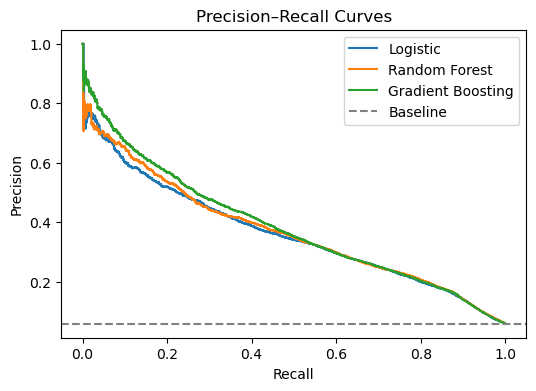

In [27]:
plt.figure(figsize=(6,4))

prec_l, rec_l, _ = precision_recall_curve(y_test, y_proba)
prec_r, rec_r, _ = precision_recall_curve(y_test, y_proba_rf)
prec_g, rec_g, _ = precision_recall_curve(y_test, y_proba_gb)

plt.plot(rec_l, prec_l, label="Logistic")
plt.plot(rec_r, prec_r, label="Random Forest")
plt.plot(rec_g, prec_g, label="Gradient Boosting")

plt.axhline(y=y_test.mean(), linestyle="--", color="gray", label="Baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()

The precision–recall curves show that all three models perform substantially better than random guessing (dashed baseline). 

Gradient Boosting consistently achieves the highest precision across most recall levels, indicating better identification of severe injury cases. Random Forest performs slightly better than logistic regression, while logistic regression remains a strong and interpretable baseline.

As recall increases, precision decreases for all models, reflecting the trade-off between identifying more severe cases and introducing more false positives.


## Feature Interpretation

### Logistic Coefficients

In [47]:
feature_names = logit.named_steps["preprocess"].get_feature_names_out()
coefs = logit.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
}).sort_values("coef", key=abs, ascending=False)

coef_df

,feature,coef
12,cat__AIR_BAG_20.0,-1.490375
224,cat__REST_USE_20.0,1.214841
139,cat__BODY_TYP_veh_83.0,1.138819
70,cat__BODY_TYP_83.0,1.138819
10,cat__AIR_BAG_8.0,1.036616
...,...,...
39,cat__BODY_TYP_29.0,0.001593
108,cat__BODY_TYP_veh_29.0,0.001593
200,cat__MONTH_veh_10.0,0.001436
188,cat__MONTH_acc_10.0,0.001436


Logistic regression coefficients represent changes in the *log-odds* of severe injury, holding all other variables constant. Positive coefficients indicate higher predicted risk, while negative coefficients indicate lower risk.

The largest-magnitude coefficients are primarily related to restraint use, airbag deployment, and vehicle type. For example, indicators related to missing or improper restraint use are associated with substantially higher odds of severe injury, while airbag-related indicators tend to reduce risk.

Age has a comparatively smaller effect after controlling for vehicle and safety characteristics, suggesting that crash context and protection systems play a stronger role than demographics alone.

### Random Forest Feature Importance

In [48]:
rf_importances = rf.named_steps["model"].feature_importances_

rf_imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": rf_importances
    })
    .sort_values("importance", ascending=False)
)

rf_imp_df.head(15)

,feature,importance
12,cat__AIR_BAG_20.0,0.177642
224,cat__REST_USE_20.0,0.103585
10,cat__AIR_BAG_8.0,0.069192
216,cat__REST_MIS_0.0,0.053812
221,cat__REST_USE_3.0,0.048442
218,cat__REST_MIS_7.0,0.046312
203,cat__REL_ROAD_1.0,0.045946
206,cat__REL_ROAD_4.0,0.045365
0,num__AGE,0.035744
11,cat__AIR_BAG_9.0,0.031714


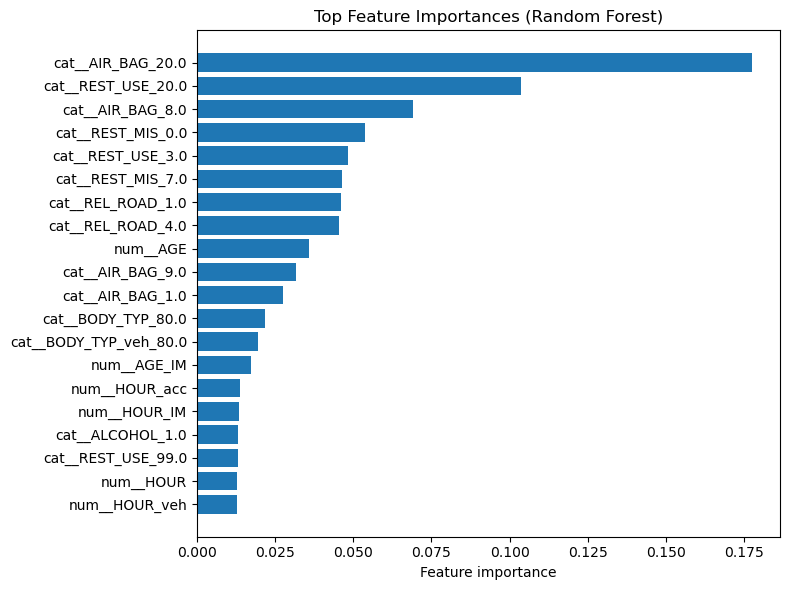

In [49]:
top_rf = rf_imp_df.head(20)

plt.figure(figsize=(8, 6))
plt.barh(top_rf["feature"][::-1], top_rf["importance"][::-1])
plt.xlabel("Feature importance")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

The Random Forest model highlights variables related to restraint use, airbag deployment, and vehicle characteristics as the most influential The Random Forest model highlights restraint use, airbag deployment, and vehicle type as the most important predictors of severe injury. These features appear repeatedly across trees, suggesting that safety equipment and vehicle structure play a major role in distinguishing high-risk crashes. Age and roadway-related variables also contribute, but to a lesser extent. Overall, the model captures nonlinear interactions between safety features and crash conditions.

### Gradient Boosting Feature Importance

In [28]:
feature_names = gb.named_steps["preprocess"].get_feature_names_out()
gb_importances = gb.named_steps["model"].feature_importances_

gb_imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": gb_importances
    })
    .sort_values("importance", ascending=False)
)

gb_imp_df.head(15)

,feature,importance
224,cat__REST_USE_20.0,0.478591
12,cat__AIR_BAG_20.0,0.170426
0,num__AGE,0.056440
10,cat__AIR_BAG_8.0,0.051048
166,cat__DRINKING_9.0,0.036337
203,cat__REL_ROAD_1.0,0.034371
206,cat__REL_ROAD_4.0,0.033707
15,cat__ALCOHOL_1.0,0.028296
1,num__AGE_IM,0.014114
236,cat__SPEEDREL_3.0,0.012366


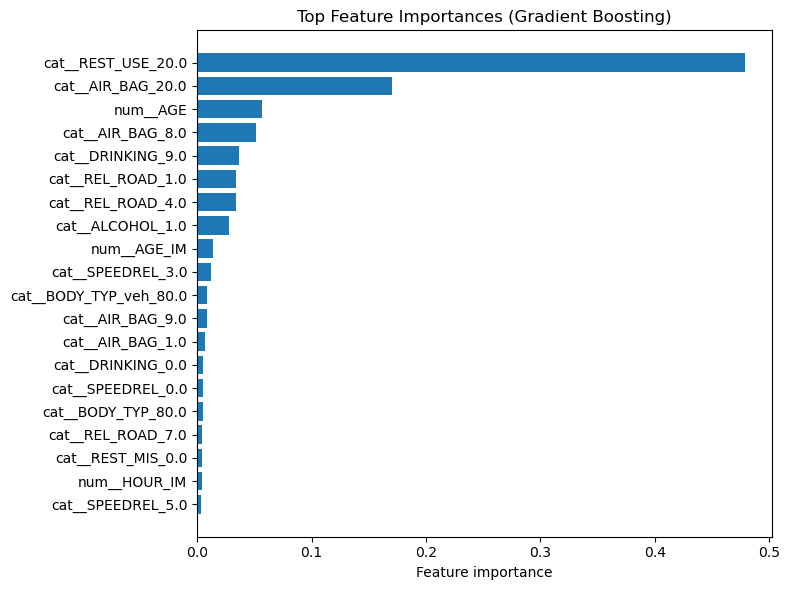

In [29]:
import matplotlib.pyplot as plt

top_n = 20
top_gb = gb_imp_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_gb["feature"][::-1], top_gb["importance"][::-1])
plt.xlabel("Feature importance")
plt.title("Top Feature Importances (Gradient Boosting)")
plt.tight_layout()
plt.show()

Gradient Boosting places even more weight on a small number of key variables, especially restraint use and airbag deployment. These features dominate the importance rankings, indicating that they are the strongest signals for predicting severe injury. Other factors such as age, alcohol involvement, and road characteristics contribute moderately. This concentration of importance reflects how boosting focuses on the most informative features to improve prediction performance.

### Interpreting Feature Importance


Across all models, variables related to restraint use and airbag deployment consistently rank as the most important predictors of severe injury. This suggests that safety equipment plays a central role in determining injury severity outcomes.

Vehicle type also appears frequently among top features, indicating that structural differences across vehicles matter. Age and alcohol-related variables contribute moderately, while time-based variables (hour, month) have relatively smaller influence once other factors are controlled for.

## Limitations

Several limitations should be noted. First, this analysis is observational and does not establish causal relationships. Feature importance reflects association rather than causation.

Second, the dataset is highly imbalanced, which complicates evaluation and may affect precision at low recall levels. Although threshold tuning helps address this, performance may vary depending on deployment goals.

Third, some variables represent coded or imputed values. These imperfections may affect model estimates.

Finally, more advanced interpretability tools could further improve understanding of individual predictions.




## Conclusion

This project demonstrates that machine learning models can effectively predict severe injury outcomes using pre-crash information from U.S. traffic data. Among the tested models, Gradient Boosting achieves the strongest overall performance, particularly in terms of precision–recall tradeoffs, while logistic regression provides a strong and interpretable baseline.

Across all models, features related to restraint use, airbag deployment, and vehicle characteristics emerge as the most important predictors, highlighting the central role of safety systems in injury severity. Environmental and temporal factors contribute additional but smaller effects.

Overall, the modeling pipeline is reproducible, leakage-aware, and suitable for extension to deployment-oriented or policy-focused analyses. These results illustrate how predictive modeling can support data-driven insights into traffic safety risk while emphasizing the importance of careful evaluation in imbalanced settings.